In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time

# random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "LiarPantsFire"
unique_name = "BERT_Finetuned"

In [2]:
vectors = np.loadtxt("../../data/processed/vectors/LiarPantsFire_BERT_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(12791, 768)

In [3]:
data = pd.read_csv("../../data/processed/liar_dataset.csv", lineterminator="\n")
data.head()

,id,label_text,statement,subject,speaker,speaker job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,context,split,label
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,train,4
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,train,2
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,train,1
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,train,4
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,train,2


In [4]:
labels_str = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']
labels_str

['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']

In [5]:
labels = data['label'].tolist()
labels[:10]

[4, 2, 1, 4, 2, 0, 3, 2, 2, 1]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['split'] == 'train'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['split'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['split'] == 'test'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['split'] == 'train'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['split'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['split'] == 'test'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(10240, 768)
(1284, 768)
(1267, 768)
(10240,)
(1284,)
(1267,)


In [8]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(128),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                self.model.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                total += targets.size(0)
#                 for i, output in enumerate(outputs.tolist()):
#                     if targets[i,0].tolist() == round(output[0]):
#                         correct += 1

#             train_acc = round(100*correct/total, 4)
#             train_accs.append(train_acc)
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                inputs, targets = test_x.to(self.device), test_y.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())

                test_loss += loss.item()
                
                preds = self.predict(test_x)
                conf_mat = ConfusionMatrix(
                    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_y]),
                    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()]),
                    binary=False
                )
                conf_mat.evaluate(logs=False)
                test_acc = conf_mat.accuracy

            test_accs.append(test_acc)
            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break

        # visualizing accuracy over epoch
        fig, ax1 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax1.plot([i for i in range(len(test_accs))], test_accs, c='r', marker="o", label='Test Acc')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_xlim(0, len(test_accs))
        ax1.set_ylim(0, 100)
        ax1.title.set_text(f"Accuracy over time (epoch)")
        ax1.legend(loc='lower right')

        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax2.plot([i for i in range(len(train_losses))], train_losses, c='b', marker="o", label='Train Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, c='r', marker="o", label='Test Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_xlim(0, len(train_losses))
        ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Loss over time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

Multiclass Classification using 4-Layer Linear Network
Using cuda
Saving after new best accuracy : 24.455
Saving after new best accuracy : 24.922
-- Epoch 50, Train Loss : 0.2024143917951733, Test Loss : 6.716739654541016
Saving after new best accuracy : 25.0
Saving after new best accuracy : 25.078
Saving after new best accuracy : 25.312
Saving after new best accuracy : 25.467
-- Epoch 100, Train Loss : 0.09955265402095392, Test Loss : 9.061184883117676
Saving after new best accuracy : 25.545
Saving after new best accuracy : 25.701
-- Epoch 150, Train Loss : 0.030111298976407852, Test Loss : 11.053083419799805
-- Epoch 200, Train Loss : 0.03903823212021962, Test Loss : 11.917630195617676
-- Epoch 250, Train Loss : 0.039334120438070386, Test Loss : 13.07176685333252
-- Epoch 300, Train Loss : 0.03563456656047492, Test Loss : 13.53905963897705
-- Epoch 350, Train Loss : 0.02970451567125565, Test Loss : 14.584320068359375
-- Epoch 400, Train Loss : 0.023357933958322974, Test Loss : 14.681

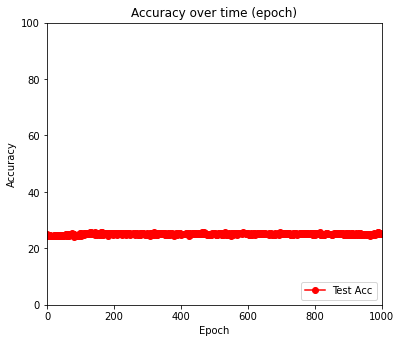

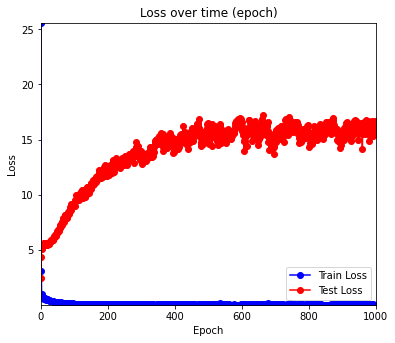

Exec Time : 214.82 seconds
loading model from ../../data/models/LiarPantsFire_4LayerNet_L2Reg_BERT_Finetuned.pth...

Validation Set
Predictions : torch.Size([1284])
1284 vs 1284
Multi Class Evaluation

Class true Evaluation
- Precision : 22.667 %
- Recall : 20.118 %
- F1 : 0.21317

Class mostly-true Evaluation
- Precision : 30.638 %
- Recall : 28.685 %
- F1 : 0.2963

Class half-true Evaluation
- Precision : 24.296 %
- Recall : 27.823 %
- F1 : 0.2594

Class barely-true Evaluation
- Precision : 21.967 %
- Recall : 28.27 %
- F1 : 0.24723

Class false Evaluation
- Precision : 26.415 %
- Recall : 26.616 %
- F1 : 0.26515

Class pants-fire Evaluation
- Precision : 42.222 %
- Recall : 16.379 %
- F1 : 0.23602

Combined Evaluation
- Accuracy : 25.779 %
- Precision : 28.034 %
- Recall : 24.649 %
- F1 : 0.26233

- Average Confidence : 100.0 %
Model, Combined,,,,true,,,mostly-true,,,half-true,,,barely-true,,,false,,,pants-fire,,,
LiarPantsFire_4LayerNet_L2Reg_BERT_Finetuned Validation, 25.779, 28.0

In [9]:
print("Multiclass Classification using 4-Layer Linear Network")
start = time.time()
model_name = f"{dataset_name}_4LayerNet_L2Reg_{unique_name}"
model = NNClassifier(train_vectors.shape[1], n_output=6, criterion=nn.CrossEntropyLoss)
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=512)
print(f"Exec Time : {round(time.time() - start, 2)} seconds")

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\nValidation Set")
preds = model.predict(val_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in val_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Validation"
)
conf_mat.evaluate(classes=labels_str)

print("\nTest Set")
preds = model.predict(test_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Test"
)
conf_mat.evaluate(classes=labels_str)